In [64]:
import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader

import models.modelsCNN as modelsCNN
import models.optimizer as optimizer

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
from skimage import io,measure
import scipy.stats
import utils.plot
import models.train_metaClf

import sys
import os
from nmco.utils.run_nuclear_feature_extraction import run_nuclear_chromatin_feat_ext
from tqdm import tqdm
import statsmodels.stats.multitest as multitest
import networkx as nx

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

resolution='5'
savedir_baseline='/data/xzhang/neuro/results/jointClustering/baseline/res'+resolution
with open(os.path.join(savedir_baseline,'pca_dapi_600'), 'rb') as output:
    pca_dapi=pickle.load(output)
with open(os.path.join(savedir_baseline,'pca_gfap_600'), 'rb') as output:
    pca_gfap=pickle.load(output)
with open(os.path.join(savedir_baseline,'pca_map2_600'), 'rb') as output:
    pca_map2=pickle.load(output)
with open(os.path.join(savedir_baseline,'pca_lmnb_600'), 'rb') as output:
    pca_lmnb=pickle.load(output)
with open(os.path.join(savedir_baseline,'modAll'), 'rb') as output:
    modAll=pickle.load(output)
with open(os.path.join(savedir_baseline,'silAll'), 'rb') as output:
    silAll=pickle.load(output)
with open(os.path.join(savedir_baseline,'moddapi'), 'rb') as output:
    moddapi=pickle.load(output)
with open(os.path.join(savedir_baseline,'sildapi'), 'rb') as output:
    sildapi=pickle.load(output)
with open(os.path.join(savedir_baseline,'modgfap'), 'rb') as output:
    modgfap=pickle.load(output)
with open(os.path.join(savedir_baseline,'silgfap'), 'rb') as output:
    silgfap=pickle.load(output)
with open(os.path.join(savedir_baseline,'modmap2'), 'rb') as output:
    modmap2=pickle.load(output)
with open(os.path.join(savedir_baseline,'silmap2'), 'rb') as output:
    silmap2=pickle.load(output)
with open(os.path.join(savedir_baseline,'modlmnb'), 'rb') as output:
    modlmnb=pickle.load(output)
with open(os.path.join(savedir_baseline,'sillmnb'), 'rb') as output:
    sillmnb=pickle.load(output)
with open(os.path.join(savedir_baseline,'leidenRes3_10samples'), 'rb') as output:
    leidenResAll=pickle.load(output)
    
savedir_processed='/data/xzhang/neuro/processed'
resDir='/data/xzhang/neuro/results/plots/cnnvaeexp0_segNucall'
saveDir=os.path.join(savedir_baseline,'cnnvaeexp0_segNucall')
if not os.path.exists(saveDir):
    os.mkdir(saveDir)


with open(os.path.join(resDir,'leiden_res'+resolution), 'rb') as output:
    finalPartition=pickle.load(output)
    
jointPartition=np.copy(finalPartition)
modFrac=0.3
modFrac_dapi=(moddapi/modAll>modFrac).astype(int)
modFrac_map2=(modmap2/modAll>modFrac).astype(int)
modFrac_gfap=(modgfap/modAll>modFrac).astype(int)
modFrac_lmnb=(modlmnb/modAll>modFrac).astype(int)
modFrac_sum=modFrac_dapi+modFrac_gfap+modFrac_lmnb+modFrac_map2

silAll_mean=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    silAll_mean[c]=np.mean(silAll[jointPartition==c])
    
sildapi_mean=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    sildapi_mean[c]=np.mean(sildapi[jointPartition==c])
    
silgfap_mean=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    silgfap_mean[c]=np.mean(silgfap[jointPartition==c])

silmap2_mean=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    silmap2_mean[c]=np.mean(silmap2[jointPartition==c])
sillmnb_mean=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    sillmnb_mean[c]=np.mean(sillmnb[jointPartition==c])
silAll_pos=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    silAll_pos[c]=np.sum(silAll[jointPartition==c]>0)/np.sum(jointPartition==c)
sildapi_pos=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    sildapi_pos[c]=np.sum(sildapi[jointPartition==c]>0)/np.sum(jointPartition==c)
silmap2_pos=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    silmap2_pos[c]=np.sum(silmap2[jointPartition==c]>0)/np.sum(jointPartition==c)
silgfap_pos=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    silgfap_pos[c]=np.sum(silgfap[jointPartition==c]>0)/np.sum(jointPartition==c)
sillmnb_pos=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    sillmnb_pos[c]=np.sum(sillmnb[jointPartition==c]>0)/np.sum(jointPartition==c)

silmean_frac=0.3
silmean_frac_neg=2
def comparesilmean(sildapi_mean,silAll_mean,silmean_frac,silmean_frac_neg):
    silmean_frac_dapi=np.zeros(silAll_mean.size)
    sildapi_mean_posIdx=np.arange(silAll_mean.size)[sildapi_mean>0]
    sildapi_mean_negIdx=np.arange(silAll_mean.size)[sildapi_mean<0]
#     print(sildapi_mean_negIdx[sildapi_mean[sildapi_mean<0]>(silAll_mean[sildapi_mean<0]*silmean_frac_neg)])
    silmean_frac_dapi[sildapi_mean_posIdx[sildapi_mean[sildapi_mean>0]>(silAll_mean[sildapi_mean>0]*silmean_frac)]]=1
    silmean_frac_dapi[sildapi_mean_negIdx[sildapi_mean[sildapi_mean<0]>(silAll_mean[sildapi_mean<0]*silmean_frac_neg)]]=1

    return silmean_frac_dapi

silmean_frac_dapi=comparesilmean(sildapi_mean,silAll_mean,silmean_frac,silmean_frac_neg)
silmean_frac_gfap=comparesilmean(silgfap_mean,silAll_mean,silmean_frac,silmean_frac_neg)
silmean_frac_map2=comparesilmean(silmap2_mean,silAll_mean,silmean_frac,silmean_frac_neg)
silmean_frac_lmnb=comparesilmean(sillmnb_mean,silAll_mean,silmean_frac,silmean_frac_neg)

silmean_frac_sum=silmean_frac_dapi+silmean_frac_gfap+silmean_frac_map2+silmean_frac_lmnb

silpos_frac=0.3
silpos_dapi=(sildapi_pos/silAll_pos>silpos_frac).astype(int)
silpos_gfap=(silgfap_pos/silAll_pos>silpos_frac).astype(int)
silpos_map2=(silmap2_pos/silAll_pos>silpos_frac).astype(int)
silpos_lmnb=(sillmnb_pos/silAll_pos>silpos_frac).astype(int)

silPos_sum=silpos_dapi+silpos_gfap+silpos_map2+silpos_lmnb


clusterIdx_pass=np.arange(np.unique(finalPartition).size)[(modFrac_sum>1)+(silmean_frac_sum>1)+(silPos_sum>1)]

nsamples=10
leidenJoint_overlap=np.zeros((np.unique(jointPartition).size,nsamples))
for cj in np.unique(jointPartition):
    for s in range(nsamples):
        _,counts=np.unique(leidenResAll[jointPartition==cj,s],return_counts=True)
        leidenJoint_overlap[cj,s]=np.max(counts)/np.sum(jointPartition==cj)

overlap_mean=np.mean(leidenJoint_overlap,axis=1)
overlap_std=np.std(leidenJoint_overlap,axis=1)

overlap_mean=np.mean(leidenJoint_overlap,axis=1)
overlap_std=np.std(leidenJoint_overlap,axis=1)

randomAll=np.zeros((leidenResAll.shape[0],nsamples)).astype(int)

for s in range(nsamples):
    randomS=np.copy(jointPartition)
    np.random.seed(s)
    np.random.shuffle(randomS)

    randomAll[:,s]=randomS
leidenJoint_overlap_random=np.zeros((np.unique(jointPartition).size,nsamples))
for cj in np.unique(jointPartition):
    for s in range(nsamples):
        _,counts=np.unique(randomAll[jointPartition==cj,s],return_counts=True)
        leidenJoint_overlap_random[cj,s]=np.max(counts)/np.sum(jointPartition==cj)

overlap_mean_random=np.mean(leidenJoint_overlap_random,axis=1)
overlap_std_random=np.std(leidenJoint_overlap_random,axis=1)

clusterIdx_robust=np.arange(np.unique(finalPartition).size)[(overlap_mean-overlap_std)>(overlap_mean_random+overlap_std_random)]
finalPartition_keep=np.intersect1d(clusterIdx_robust,clusterIdx_pass)


    
with open(os.path.join(savedir_processed,'meta_processed'), 'rb') as output:
    meta=pickle.load(output)

# annoUsed=np.array(['AAO', 'AAD', 'Duration', 'Gender','Clinical Diag','Brain Weight', 'Mutations',
#                    'APOE', 'Braak Tau', 'Thal Phase', 'CERAD', 'CAA', 'SVD','alpha-syn', 'TDP43'])
annoUsed=np.array(['Path Diag','Clinical Diag','Brain Weight', 'Mutations',
                   'APOE', 'Braak Tau', 'Thal Phase', 'CERAD', 'CAA', 'SVD','alpha-syn', 'TDP43',
                   'AAO', 'AAD', 'Duration', 'Gender'])
annoUsed_numeric=np.array(['AAO', 'AAD', 'Duration','Brain Weight','Braak Tau', 'Thal Phase', 'CERAD', 'CAA', 'SVD'])

meta=meta[annoUsed]
stains=np.array(['DAPI','GFAP','MAP2','LMNB'])

    
finalPartition_keepIdx=np.repeat(False, finalPartition.size)
for c in finalPartition_keep:
    finalPartition_keepIdx[finalPartition==c]=True
finalPartition_keep_input=np.copy(finalPartition)
finalPartition_keep_input[np.logical_not(finalPartition_keepIdx)]=-1



In [3]:
with open(os.path.join(savedir_processed,'allPatientID'), 'rb') as output:
    allPatientIDs=pickle.load(output)
meta=meta.loc[np.unique(allPatientIDs)]

with open(os.path.join(savedir_processed,'allImgNames'), 'rb') as output:
    allImgNames=pickle.load(output)
print(np.unique(allImgNames).size)
print(np.unique(allPatientIDs).size)

with open(os.path.join(savedir_processed,'allImgs_noMaxPerc_minmax_segNuc'), 'rb') as output:
    allImg=pickle.load(output)

64
50


In [4]:
allImg.shape

(97530, 4, 128, 128)

In [ ]:
#NMCO features for DAPI
#NMCO features for LMNB that differ from DAPI
nmco_dapi=pd.DataFrame()
nmco_lmnb=pd.DataFrame()
for i in range(allImg.shape[0]):
    if i%1000==0:
        print(i)
    segCurr=np.zeros((128,128))
    segCurr[allImg[i,0]>0]=1
    nmco_dapi = pd.concat([nmco_dapi, run_nuclear_chromatin_feat_ext(allImg[i,0]*255,segCurr,'none',hc_threshold=1.5)])
    nmco_lmnb = pd.concat([nmco_lmnb,run_nuclear_chromatin_feat_ext(allImg[i,3]*255,segCurr,'none',hc_threshold=1.5)[lmnbfeatures]])
    

In [207]:
with open(os.path.join(savedir_processed,'nmco_dapi'), 'wb') as output:
    pickle.dump(nmco_dapi,output,pickle.HIGHEST_PROTOCOL)
with open(os.path.join(savedir_processed,'nmco_lmnb'), 'wb') as output:
    pickle.dump(nmco_lmnb,output,pickle.HIGHEST_PROTOCOL)

In [137]:
map2gfapFeatureNames=['fragCounts','area_mean','area_std','area_sum','area_max','major_axis_length_mean','major_axis_length_std','major_axis_length_sum']
map2gfapFeatureNames=np.concatenate((map2gfapFeatureNames,np.char.add('major_axis_length_bins',np.arange(9).astype(int).astype(str))))
map2gfapFeatureNames=np.concatenate((map2gfapFeatureNames,['minor_axis_length_mean','minor_axis_length_std']))
map2gfapFeatureNames=np.concatenate((map2gfapFeatureNames,np.char.add('minor_axis_length_bins',np.arange(3).astype(int).astype(str))))
map2gfapFeatureNames=np.concatenate((map2gfapFeatureNames,['eccentricity_mean','eccentricity_std','solidity_mean','solidity_std','extent_mean','extent_std','perimeter_mean','perimeter_std','perimeter_sum']))
map2gfapFeatureNames=np.concatenate((map2gfapFeatureNames,np.char.add(['mean_intensity', 'max_intensity'],'_mean')))
map2gfapFeatureNames=np.concatenate((map2gfapFeatureNames,np.char.add(['mean_intensity', 'max_intensity'],'_std')))
map2gfapFeatureNames=np.concatenate((map2gfapFeatureNames,np.char.add(['mean_intensity', 'max_intensity'],'_max')))
map2gfapFeatureNames=np.concatenate((map2gfapFeatureNames,['orientation_std','aspect_ratio_mean','aspect_ratio_std']))

def getmap2gfapFeatures(imgs,thresh=0.2,minFragSize=20):
    testImg=np.copy(imgs)
    testImg[testImg>thresh]=1
    testImg[testImg<=thresh]=0
    testImg_label=measure.label(testImg)
    
    resFeatures=np.zeros((imgs.shape[0],40))
    
    for imgIdx in tqdm(range(imgs.shape[0])):
        testImg_label_i=testImg_label[imgIdx]
        
        #filter by size
        fragID,fragSize=np.unique(testImg_label_i,return_counts=True)
        fragID_sizeFiltered=fragID[fragSize>=minFragSize]
        for i in fragID[fragSize<minFragSize]:
            testImg_label_i[testImg_label_i==i]=0

        #feature of each fragment
        fragFeatures=pd.DataFrame(measure.regionprops_table(testImg_label_i,intensity_image=imgs[imgIdx],properties=[
            'area', 'major_axis_length', 'minor_axis_length', 'eccentricity',
            'solidity', 'extent', 'perimeter','mean_intensity', 'max_intensity', 'orientation'
        ]))
        summary = fragFeatures.agg(['count', 'mean', 'std', 'min', 'max', 'sum'])
        length_bins, _ = np.histogram(fragFeatures['major_axis_length'], bins=np.linspace(0, allImg.shape[2], 10))
        width_bins, _ = np.histogram(fragFeatures['minor_axis_length'], bins=np.linspace(0, allImg.shape[2]/3, 4))
        aspectratio=fragFeatures['major_axis_length']/fragFeatures['minor_axis_length']
    
        resFeatures[imgIdx,0:5]=summary.loc[['count','mean','std','sum','max'],'area']
        resFeatures[imgIdx,5:8]=summary.loc[['mean','std','sum'],'major_axis_length']
        resFeatures[imgIdx,8:17]=length_bins
        resFeatures[imgIdx,17:19]=summary.loc[['mean','std'],'minor_axis_length']
        resFeatures[imgIdx,19:22]=width_bins
        resFeatures[imgIdx,22:24]=summary.loc[['mean','std'],'eccentricity']
        resFeatures[imgIdx,24:26]=summary.loc[['mean','std'],'solidity']
        resFeatures[imgIdx,26:28]=summary.loc[['mean','std'],'extent']
        resFeatures[imgIdx,28:31]=summary.loc[['mean','std','sum'],'perimeter']
        resFeatures[imgIdx,31:37]=summary.loc[['mean','std','max'],['mean_intensity', 'max_intensity']].to_numpy().flatten()
        resFeatures[imgIdx,37]=summary.loc['std','orientation']
        resFeatures[imgIdx,38]=np.mean(aspectratio)
        resFeatures[imgIdx,39]=np.std(aspectratio)

        

In [ ]:
features_map2=getmap2gfapFeatures(allImg[:,2])
with open(os.path.join(savedir_processed,'features_map2'), 'wb') as output:
    pickle.dump(features_map2,output,pickle.HIGHEST_PROTOCOL) 

In [ ]:
features_gfap=getmap2gfapFeatures(allImg[:,1])
with open(os.path.join(savedir_processed,'features_gfap'), 'wb') as output:
    pickle.dump(features_gfap,output,pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(os.path.join(savedir_processed,'nmco_dapi'), 'rb') as output:
    nmco_dapi=pickle.load(output)
with open(os.path.join(savedir_processed,'nmco_lmnb'), 'rb') as output:
    nmco_lmnb=pickle.load(output)
with open(os.path.join(savedir_processed,'invagination/allInvag'), 'rb') as output:
    allInvag=pickle.load(output)
    
allInvag=np.sum(allInvag>0,axis=(1,2))
allInvag=allInvag/np.sum(allImg[:,3]>0,axis=(1,2))
allInvag[allInvag>np.percentile(allInvag,99.9)]=np.percentile(allInvag,99.9)
nmco_lmnb['invagination']=allInvag
    
nmco_dapi=nmco_dapi.iloc[:,1:]  
nmco_dapi_names=nmco_dapi.columns
nmco_lmnb_names=nmco_lmnb.columns

nmco_dapi=nmco_dapi.astype(float)
nmco_dapi=scipy.stats.zscore(nmco_dapi,axis=0,nan_policy='omit')
nmco_dapi=np.nan_to_num(nmco_dapi,nan=0)
nmco_lmnb=nmco_lmnb.astype(float)
nmco_lmnb=scipy.stats.zscore(nmco_lmnb,axis=0,nan_policy='omit')
nmco_lmnb=np.nan_to_num(nmco_lmnb,nan=0)

nonzeroDapi=np.array(np.sum(np.logical_and(nmco_dapi!=0,np.isfinite(nmco_dapi)),axis=0)>100)
nonzeroLMNB=np.array(np.sum(np.logical_and(nmco_lmnb!=0,np.isfinite(nmco_lmnb)),axis=0)>100)
nmco_dapi=nmco_dapi[:,nonzeroDapi]
nmco_lmnb=nmco_lmnb[:,nonzeroLMNB]
nmco_dapi_names=nmco_dapi_names[nonzeroDapi]
nmco_lmnb_names=nmco_lmnb_names[nonzeroLMNB]



In [565]:
with open(os.path.join(savedir_processed,'nmco_dapi'), 'rb') as output:
    nmco_dapi_raw=pickle.load(output)
nmco_dapi_raw

,label,min_calliper,max_calliper,smallest_largest_calliper,min_radius,max_radius,med_radius,avg_radius,mode_radius,d25_radius,...,moments_central-3-1,moments_central-3-2,moments_central-3-3,moments_hu-0,moments_hu-1,moments_hu-2,moments_hu-3,moments_hu-4,moments_hu-5,moments_hu-6
0,1,48,54,0.888889,22.426479,26.893967,24.568504,24.727505,22.426479,23.747229,...,9.851737e+06,1.670108e+07,2.487239e+09,0.160430,0.000382,3.008645e-06,1.392084e-08,-1.999007e-15,-2.134919e-10,2.029885e-15
0,1,46,49,0.938776,21.812234,24.141625,22.946066,22.956318,21.812234,22.586604,...,9.347079e+05,6.212992e+06,4.506330e+07,0.159372,0.000027,8.781220e-06,4.241349e-09,-2.186552e-16,-3.520327e-12,-7.887824e-16
0,1,38,45,0.844444,17.567254,22.160453,20.625363,20.295964,17.567254,19.234665,...,2.209287e+06,2.762494e+06,3.579130e+08,0.161200,0.000616,4.522033e-06,3.246924e-08,-1.189484e-14,-7.395803e-10,3.647657e-15
0,1,32,34,0.941176,14.110409,17.041787,15.783171,15.757180,14.110409,15.309205,...,3.653678e+05,-2.470977e+06,3.019998e+07,0.159963,0.000063,5.199073e-05,5.691835e-08,8.207128e-14,4.167803e-10,5.339765e-14
0,1,40,45,0.888889,18.921330,22.248444,20.066949,20.396075,18.921330,19.710119,...,3.248344e+06,6.704484e+05,5.681920e+08,0.160128,0.000261,7.727828e-08,8.827700e-10,-6.584511e-18,8.079959e-12,-3.131464e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1,58,77,0.753247,26.096435,39.651550,32.351516,32.605771,26.096435,29.895313,...,-1.408800e+08,7.307943e+08,-6.717296e+10,0.166905,0.002125,1.184987e-04,2.212580e-06,4.910995e-12,2.397618e-09,-3.548839e-11
0,1,15,17,0.882353,6.536653,8.263341,7.430662,7.421583,6.536653,7.165221,...,-6.100020e+03,4.514645e+03,-1.548950e+05,0.160055,0.000185,1.643391e-05,6.452975e-08,6.177150e-14,7.442083e-10,-2.449894e-14
0,1,14,19,0.736842,6.316353,9.027422,8.139665,7.932548,6.316353,7.482606,...,-1.223735e+04,1.501000e+03,-2.960707e+05,0.164988,0.001883,1.592549e-07,5.083143e-10,4.566916e-18,2.021248e-11,-2.445784e-19
0,1,23,30,0.766667,10.614457,14.593067,11.624254,12.046373,10.614457,11.230552,...,-3.034021e+05,-1.397407e+05,-2.323134e+07,0.163224,0.001138,1.617487e-06,8.693565e-08,3.215342e-14,2.550914e-09,-5.377383e-15


In [ ]:
map2gfapFeatureNames=['fragCounts','area_mean','area_std','area_sum','area_max','major_axis_length_mean','major_axis_length_std','major_axis_length_sum']
map2gfapFeatureNames=np.concatenate((map2gfapFeatureNames,np.char.add('major_axis_length_bins',np.arange(9).astype(int).astype(str))))
map2gfapFeatureNames=np.concatenate((map2gfapFeatureNames,['minor_axis_length_mean','minor_axis_length_std']))
map2gfapFeatureNames=np.concatenate((map2gfapFeatureNames,np.char.add('minor_axis_length_bins',np.arange(3).astype(int).astype(str))))
map2gfapFeatureNames=np.concatenate((map2gfapFeatureNames,['eccentricity_mean','eccentricity_std','solidity_mean','solidity_std','extent_mean','extent_std','perimeter_mean','perimeter_std','perimeter_sum']))
map2gfapFeatureNames=np.concatenate((map2gfapFeatureNames,np.char.add(['mean_intensity', 'max_intensity'],'_mean')))
map2gfapFeatureNames=np.concatenate((map2gfapFeatureNames,np.char.add(['mean_intensity', 'max_intensity'],'_std')))
map2gfapFeatureNames=np.concatenate((map2gfapFeatureNames,np.char.add(['mean_intensity', 'max_intensity'],'_max')))
map2gfapFeatureNames=np.concatenate((map2gfapFeatureNames,['orientation_std','aspect_ratio_mean','aspect_ratio_std']))

with open(os.path.join(savedir_processed,'features_map2'), 'rb') as output:
    features_map2=pickle.load(output)
with open(os.path.join(savedir_processed,'features_gfap'), 'rb') as output:
    features_gfap=pickle.load(output)

features_map2=features_map2.astype(float)
features_map2=scipy.stats.zscore(features_map2,axis=0,nan_policy='omit')
features_map2=np.nan_to_num(features_map2,nan=0)
features_gfap=features_gfap.astype(float)
features_gfap=scipy.stats.zscore(features_gfap,axis=0,nan_policy='omit')
features_gfap=np.nan_to_num(features_gfap,nan=0)

nonzeroMAP2=np.array(np.sum(np.logical_and(features_map2!=0,np.isfinite(features_map2)),axis=0)>100)
nonzeroGFAP=np.array(np.sum(np.logical_and(features_gfap!=0,np.isfinite(features_gfap)),axis=0)>100)
features_map2=features_map2[:,nonzeroMAP2]
features_gfap=features_gfap[:,nonzeroGFAP]
features_map2_names=map2gfapFeatureNames[nonzeroMAP2]
features_gfap_names=map2gfapFeatureNames[nonzeroGFAP]


### by cluster

In [40]:
plotsavepath='/data/xzhang/neuro/results/jointClustering/baseline/res5/cnnvaeexp0_segNucall/imgFeatures/byCluster'

In [141]:
plotIGsavepath_thresh='/data/xzhang/neuro/results/jointClustering/baseline/res5/cnnvaeexp0_segNucall/metadataClf/igPlotsControl/thresh'
with open(os.path.join(plotIGsavepath_thresh,'igPlotAll_mean'), 'rb') as output:
    igPlotAll_mean=pickle.load(output)
with open(os.path.join(plotIGsavepath_thresh,'igPlotAll_std'), 'rb') as output:
    igPlotAll_std=pickle.load(output)
with open(os.path.join(plotIGsavepath_thresh,'igPlotAll_mean_counts'), 'rb') as output:
    igPlotAll_mean_counts=pickle.load(output)
with open(os.path.join(plotIGsavepath_thresh,'igPlotAll_std_counts'), 'rb') as output:
    igPlotAll_std_counts=pickle.load(output)
# igPlotAll_mean=np.concatenate((igPlotAll_mean[:,1:],igPlotAll_mean_counts),axis=0)
igNames=np.array(['Path Diag_AD', 'Path Diag_FTLD-TDPC', 'Path Diag_PSP','Path Diag_IPD', 'APOE_34', 'TDP43_1', 'alpha-syn_1'])
igNames_counts=np.array(['counts_APOE_34', 'counts_TDP43_1'])

In [142]:
clusterUnique,clusterUnique_size=np.unique(finalPartition_keep_input,return_counts=True)

In [135]:
cluster2plot_sizeFilter=np.array([ 0.,  1.,  2.,  3.,  4.,  7., 11., 13., 14., 17., 18., 19., 20.,
       21., 28., 32., 34., 36., 39., 53., 62., 66., 74., 82., 84., 85.,
       94., 97., 99.])

In [601]:
def compareClusters_mean(featureMtx,featureNames,igPlotAll_mean,igNames,clusterUnique,plotsavepath,k=8):
    for catIdx in range(igNames.size):
        cat=igNames[catIdx]
        print(cat)
        plotsavepath_cat=os.path.join(plotsavepath,cat)
        if not os.path.exists(plotsavepath_cat):
            os.mkdir(plotsavepath_cat)
        topk=clusterUnique[np.argsort(np.abs(igPlotAll_mean[catIdx]))[-k:]]
    
        print(topk)
        pltMtx=np.zeros((k,featureMtx.shape[1]))
        
        topkIdx=np.repeat(False,finalPartition_keep_input.size)
        for cidx in range(k):
            c=topk[cidx]
            topkIdx[finalPartition_keep_input==c]=True
            pltMtx[cidx]=np.mean(featureMtx[finalPartition_keep_input==c],axis=0)
        topk_features=featureMtx[topkIdx]
        
        sigIdx=np.array([])
        stats={}
        pvals=np.array([])
        pval_startIdx=[]
        currIdx=0
        for l in topk:
            stats[l]=pd.DataFrame({'avg':np.mean(featureMtx[finalPartition_keep_input==l],axis=0),
                               'std':np.std(featureMtx[finalPartition_keep_input==l],axis=0),
                               'fc':(np.mean(featureMtx[finalPartition_keep_input==l],axis=0)/np.mean(featureMtx[finalPartition_keep_input!=l],axis=0))},
                              index=featureNames)
            pvalues=scipy.stats.mannwhitneyu(featureMtx[finalPartition_keep_input==l],featureMtx[finalPartition_keep_input!=l])[1]
            stats[l]['pval']=pvalues
            pvals=np.concatenate((pvals,pvalues))
            pval_startIdx.append(currIdx)
            currIdx+=pvalues.size

        pval_corr=multitest.fdrcorrection(pvals,0.05,'indep')[1]

        for lidx in range(k):
            l=topk[lidx]
            stats[l]['pval_corr']=pval_corr[pval_startIdx[lidx]:(pval_startIdx[lidx]+stats[l]['pval'].size)]
            stats[l].to_csv(os.path.join(plotsavepath_cat,str(k)+'clusters_stats05_'+str(l)+'.csv'))
            sigIdx=np.concatenate((sigIdx,np.arange(stats[l].shape[0])[np.logical_and(np.abs(stats[l]['avg'])>1,np.logical_and(stats[l]['pval_corr']<0.001,np.logical_or(stats[l]['fc']<0.5,stats[l]['fc']>2)))]))

        sigIdx=np.unique(sigIdx).astype(int)
        print(sigIdx.size)
        if sigIdx.size==0:
            continue
        
        df = pd.DataFrame(featureMtx[:,sigIdx],columns=featureNames[sigIdx])
        corr = df.corr()
        # keep only upper triangle elements (excluding diagonal elements)
        mask_keep = np.triu(np.ones(corr.shape), k=1).astype('bool').reshape(corr.size)
        # melt (unpivot) the dataframe and apply mask
        sr = corr.stack()[mask_keep]
        # filter and get names
        edges = sr[sr > 0.8].reset_index().values[:, :2]
        g = nx.from_edgelist(edges)
        ls_cc = []
        for cc in nx.connected_components(g):
            print(list(cc))
            ls_cc.extend(list(cc))
        for n in featureNames[sigIdx]:
            if n not in ls_cc:
                ls_cc.append(n)
                
        df_plot=pd.DataFrame(pltMtx[:,sigIdx],columns=featureNames[sigIdx])
        df_plot=df_plot[ls_cc]

        fig, ax = plt.subplots(figsize=(15/100*(df_plot.shape[1]+6.5), 6))
        im = ax.imshow(df_plot.to_numpy(),cmap='seismic',vmin=-np.max(np.abs(pltMtx[:,sigIdx])),vmax=np.max(np.abs(pltMtx[:,sigIdx])))
        ax.set_xticks(np.arange(sigIdx.size))
        ax.set_xticklabels(ls_cc)
        ax.set_yticks(np.arange(k))
        ax.set_yticklabels(topk.astype(str))
        plt.setp(ax.get_xticklabels(), rotation=90, ha="right",rotation_mode="anchor")
        #     fig.set_figheight(35)
        #     fig.set_figwidth(35)
        fig.colorbar(im,shrink=0.5)
        fig.tight_layout()
        plt.savefig(os.path.join(plotsavepath_cat,str(k)+'clusters_pval001_fc2_avg05_ordered_topkonly.jpg'))
        plt.close()

In [578]:
nmco_dapi.shape

(97530, 194)

In [ ]:
compareClusters_mean(nmco_dapi,nmco_dapi_names,igPlotAll_mean,igNames,clusterUnique.astype(int),os.path.join(plotsavepath,'dapi'))
compareClusters_mean(nmco_dapi,nmco_dapi_names,igPlotAll_mean_counts,igNames_counts,clusterUnique.astype(int)[1:],os.path.join(plotsavepath,'dapi'))


In [171]:
compareClusters_mean(nmco_lmnb,nmco_lmnb_names,igPlotAll_mean,igNames,clusterUnique.astype(int),os.path.join(plotsavepath,'lmnb'))
compareClusters_mean(nmco_lmnb,nmco_lmnb_names,igPlotAll_mean_counts,igNames_counts,clusterUnique.astype(int)[1:],os.path.join(plotsavepath,'lmnb'))

Path Diag_AD
[ 0 -1 32 28 74 20  7 11]
29
Path Diag_FTLD-TDPC
[62  0 74 11 94 17 -1  3]
54
Path Diag_PSP
[21 -1 28 14  7 94 19 62]
48
Path Diag_IPD
[ 4 28 -1  2  7 21 14 17]
37
APOE_34
[21  0 94 74  3 32  7 11]
50
TDP43_1
[53  0 39 11 -1  3 74  1]
19
alpha-syn_1
[18 -1 13 34  0  1 28 11]
20
counts_APOE_34
[ 82  85  39  62  99 101  11  97]
36
counts_TDP43_1
[ 11  66  36  97  62  84 100  39]
33


In [592]:
features_map2.shape

(97530, 39)

In [602]:
compareClusters_mean(features_map2,features_map2_names,igPlotAll_mean[[1]],igNames[[1]],clusterUnique.astype(int),os.path.join(plotsavepath,'map2'))
compareClusters_mean(features_map2,features_map2_names,igPlotAll_mean_counts,igNames_counts,clusterUnique.astype(int)[1:],os.path.join(plotsavepath,'map2'))

Path Diag_FTLD-TDPC
[62  0 74 11 94 17 -1  3]
2
['perimeter_sum', 'area_sum']


In [173]:
compareClusters_mean(features_gfap,features_gfap_names,igPlotAll_mean,igNames,clusterUnique.astype(int),os.path.join(plotsavepath,'gfap'))
compareClusters_mean(features_gfap,features_gfap_names,igPlotAll_mean_counts,igNames_counts,clusterUnique.astype(int)[1:],os.path.join(plotsavepath,'gfap'))

Path Diag_AD
[ 0 -1 32 28 74 20  7 11]
8
Path Diag_FTLD-TDPC
[62  0 74 11 94 17 -1  3]
9
Path Diag_PSP
[21 -1 28 14  7 94 19 62]
7
Path Diag_IPD
[ 4 28 -1  2  7 21 14 17]
0
APOE_34
[21  0 94 74  3 32  7 11]
9
TDP43_1
[53  0 39 11 -1  3 74  1]
8
alpha-syn_1
[18 -1 13 34  0  1 28 11]
0
counts_APOE_34
[ 82  85  39  62  99 101  11  97]
1
counts_TDP43_1
[ 11  66  36  97  62  84 100  39]


/tmp/ipykernel_1048967/3128172600.py:78: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


1


/tmp/ipykernel_1048967/3128172600.py:78: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


In [225]:
def getclusterprop(meta,metaCat1,cellIdx,clusterAll):
    allImgNames_a=allImgNames[meta==metaCat1]
    sUnique,sidx_start=np.unique(allImgNames_a,return_index=True)
    
    #get cluster composition
    clusterUnique=np.unique(clusterAll[cellIdx])
    inputCluster=np.zeros((sUnique.size,clusterUnique.size))
    for i in range(sUnique.size):
        clusterRes_i=clusterAll[allImgNames==sUnique[i]]
        for j in range(clusterUnique.size):
            inputCluster[i,j]=np.sum(clusterRes_i==clusterUnique[j])
    inputAll_all=inputCluster/np.sum(inputCluster,axis=1,keepdims=True)
    return np.mean(inputAll_all,axis=0)

In [308]:
def compareClusters_mean_feature2prop(featureAll,featureName,meta,metaCat1,metaCat2,clusterAll,plotsavepath):
#     plotsavepath_cat=os.path.join(plotsavepath,featureName+'_'+metaCat1+'_'+metaCat2)
#     if not os.path.exists(plotsavepath_cat):
#         os.mkdir(plotsavepath_cat)
    cellIdx=np.logical_or(meta==metaCat1,meta==metaCat2) 
    clusterUnique_all=np.unique(clusterAll[cellIdx])
    
    clusterFC=getclusterprop(meta,metaCat1,cellIdx,clusterAll)/getclusterprop(meta,metaCat2,cellIdx,clusterAll)

    featureMean=np.zeros(clusterUnique_all.size)

    for cidx in range(clusterUnique_all.size):
        featureMean[cidx]=np.mean(featureAll[cellIdx][clusterAll[cellIdx]==clusterUnique_all[cidx]])
    plt.scatter(clusterFC,featureMean)
    plt.show()
    print(scipy.stats.pearsonr(clusterFC[np.isfinite(clusterFC)],featureMean[np.isfinite(clusterFC)]))
#     plt.savefig(os.path.join(plotsavepath_cat,str(k)+'clusters_pval001_fc2_avg05_ordered_topkonly.jpg'))
#     plt.close()

In [536]:
hcCluster_all={}
hcCluster_all_dff={}
for p in np.unique(meta['Path Diag']):
    if p=='Control':
        continue
    print(p)
    incCounts=0
    decCounts=0
    hcClusters=[]
    hcClusters_diff=[]
    for c in clusterUnique:
        diff=np.mean(nmco_dapi[np.logical_and(meta.loc[allPatientIDs]['Path Diag']==p,finalPartition_keep_input==c),nmco_dapi_names=='hc_area_ec_area'])-np.mean(nmco_dapi[np.logical_and(meta.loc[allPatientIDs]['Path Diag']=='Control',finalPartition_keep_input==c),nmco_dapi_names=='hc_area_ec_area'])
        pval=scipy.stats.ttest_ind(nmco_dapi[np.logical_and(meta.loc[allPatientIDs]['Path Diag']==p,finalPartition_keep_input==c),nmco_dapi_names=='hc_area_ec_area'],nmco_dapi[np.logical_and(meta.loc[allPatientIDs]['Path Diag']=='Control',finalPartition_keep_input==c),nmco_dapi_names=='hc_area_ec_area'],alternative='two-sided')[1]
        if pval<0.05/69:
            print(c,pval,diff)
            hcClusters.append(c)
            hcClusters_diff.append(diff)
            if diff>0:
                incCounts+=1
            else:
                decCounts+=1
    print(incCounts)
    print(decCounts)
    hcCluster_all[p]=hcClusters
    hcCluster_all_dff[p]=hcClusters_diff

AD
-1 1.1395966101429223e-45 -0.2992486299946383
3 2.2300849359199697e-08 -0.5066309125786076
4 6.823317679554887e-14 0.2794056201254292
6 0.0007201662678490187 -0.2539369049611519
7 3.442744600445432e-07 0.2565429791192394
8 2.7744011562671414e-07 0.2198228405621279
10 3.31761416940871e-05 0.12826283995964805
13 2.7906241079086622e-08 -0.37349148854899744
15 0.000361070107985116 -0.2542955195909196
18 0.00017024437086669828 -0.25355265452243325
20 0.000172929649083571 -0.2846734433252783
22 0.0004876283305236843 0.21309046686120275
23 1.8622797522676581e-06 0.26078909790012145
30 8.580536080867802e-05 0.1959477879149325
34 0.00016701815438666318 0.16399482336216564
35 5.253112398336668e-09 -0.4812583083667019
38 5.895698855995627e-07 -0.4238006666531105
70 1.3475725923018002e-05 0.40650945757848156
94 7.88935622570946e-05 0.3702549118743223


/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/hom

10
9
FTLD-TDPC
-1 3.260224777326478e-66 -0.3472562175707001
1 0.0007025591712195424 -0.12115136678416388
3 5.534875985333246e-11 -0.5721055410707102
4 0.00027425424695113855 0.1236715395838998
13 1.0658077049953633e-05 -0.27717469084338986
19 0.00014043405886334044 -0.30220442112993906
35 8.623873561354174e-06 -0.39811908675862373


/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/hom

1
6
IPD
-1 4.740323925159564e-35 -0.2773112525750884
0 3.075902311122965e-07 0.16704258092151525
4 1.8364364079371793e-11 0.23782007075882283
15 4.97687377695607e-05 -0.3360117225588999
20 8.673969757314847e-09 -0.5226915206157252
35 0.00019863666771209582 -0.3957375976929355
56 1.7605119248307928e-14 -1.1182496570054192


/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/hom

2
5
PSP
-1 2.0282600262142585e-28 -0.23111593254833368
1 0.00045901023519059593 -0.12323993781029513
4 3.2267628943070817e-07 0.1936132797528693
22 0.00013621962181647367 0.23688676647700777
35 0.00017333009728622624 -0.3264636486588438
94 0.0006511337783135373 0.4035339231476072
3
3


/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/hom

In [ ]:
for p in np.unique(meta['Path Diag']):
    if p=='Control':
        continue
    print(p)
    for c in hcCluster_all[p]:
        cidx=np.logical_and(meta.loc[allPatientIDs]['Path Diag']==p,finalPartition_keep_input==c)
        x=meta.loc[allPatientIDs]['AAD'].to_numpy()[cidx]
        y=nmco_dapi[cidx,nmco_dapi_names=='hc_content_ec_content']
        fig, ax = plt.subplots(figsize=(2.5, 2.5))
        sns.regplot(x=x[x!='na'].astype(float), y=y[x!='na'].astype(float), scatter_kws={"s": 6}, line_kws={"color": "red"},robust=True)
        ax.set_xticks(np.linspace(np.min(x[x != 'na'].astype(float)), np.max(x[x != 'na'].astype(float)), np.unique(x[x!='na']).size))
        plt.tight_layout()
        plt.savefig(os.path.join(plotsavepath,'dapi','hc_content_ec_content',str(c)+'_AADregrs.pdf'))
        plt.show()
        print(c,scipy.stats.pearsonr(x=x[x!='na'].astype(float), y=y[x!='na'].astype(float)))

In [566]:
invagClusters_all={}
invagClusters_all_diff={}
for p in np.unique(meta['Path Diag']):
    if p=='Control':
        continue
    print(p)
    incCounts=0
    decCounts=0
    invagClusters=[]
    invagClusters_diff=[]
    for c in clusterUnique:
        diff=np.mean(nmco_lmnb[np.logical_and(meta.loc[allPatientIDs]['Path Diag']==p,finalPartition_keep_input==c),nmco_lmnb_names=='invagination'])-np.mean(nmco_lmnb[np.logical_and(meta.loc[allPatientIDs]['Path Diag']=='Control',finalPartition_keep_input==c),nmco_lmnb_names=='invagination'])
        pval=scipy.stats.ttest_ind(nmco_lmnb[np.logical_and(meta.loc[allPatientIDs]['Path Diag']==p,finalPartition_keep_input==c),nmco_lmnb_names=='invagination'],nmco_lmnb[np.logical_and(meta.loc[allPatientIDs]['Path Diag']=='Control',finalPartition_keep_input==c),nmco_lmnb_names=='invagination'],alternative='two-sided')[1]
        if pval<0.05/69:
            print(c,pval,diff)
            invagClusters.append(c)
            invagClusters_diff.append(diff)
            if diff>0:
                incCounts+=1
            else:
                decCounts+=1
    print(incCounts)
    print(decCounts)
    invagClusters_all[p]=invagClusters
    invagClusters_all_diff[p]=invagClusters_diff

AD
-1 9.558412695014293e-24 0.14588328255199096
1 1.0011951173080056e-10 0.1862604493249279
4 6.510089493727467e-24 0.5892896409967197
5 0.00010949791126165371 0.19159620599460794
7 2.2547036009050053e-06 0.2314555416839702
8 9.896965401051892e-17 0.49470529482689796
10 4.5245859688542713e-23 0.7359545995740178
13 0.00022003253621806246 0.09325897179880749
21 2.8034930813765604e-10 0.635258642990387
22 6.045924217666174e-06 0.22219444210058498
23 2.171225135790385e-06 0.2583169472639373
30 1.0025354037959907e-10 0.48101476159976786
34 1.3531966225568286e-05 0.25266831500989995
35 8.950076417856489e-05 0.18492831294113904
36 0.00017901284516594337 0.24557927593926654
40 7.959376408790251e-07 0.363745945248046
46 4.1724937576686356e-08 0.7823786018569441
49 0.00010187813823103417 0.2958079654025935
74 0.0006588735406032854 0.2688661876800892


/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/hom

19
0
FTLD-TDPC
-1 4.266029377844865e-65 0.2637866155483164
4 6.309689966394727e-14 0.5094358317546888
8 0.00037792491864860713 0.2103154766538704
10 6.975022736332593e-07 0.4164049311407165
11 5.903723665448064e-06 0.21074555526223404
12 0.0005906728504632031 0.19678497859208444
13 0.0004692038573724553 0.09442833963548669
18 0.00037475074161823755 0.17976610060738146
19 6.329392098458954e-05 0.20991980948358102
22 2.2766968012056857e-05 0.22388774772139725
23 1.5440551619245865e-07 0.3255350626993492
30 2.601023303368854e-05 0.36189615606543735
32 2.3335104087808813e-05 0.2879243106922122
35 3.4085535382838133e-06 0.25283866903923385
46 6.109673844264022e-05 0.6226321186196364
49 0.0002183449692175109 0.2849657762822457
66 1.1895349139918955e-05 0.33497627131042046


/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/hom

17
0
IPD
-1 3.1357093575039512e-68 0.2889608457869088
4 1.1759302022683142e-24 0.7111253517707228
5 7.00321317176031e-09 0.3071547504019351
7 1.1524932078299139e-12 0.44174178599991465
8 5.029027351050566e-10 0.4020886501614682
10 6.619997819999194e-09 0.5064622598116637
11 1.750410093624632e-09 0.31164667123722156
12 1.2113252557270275e-08 0.3184798993769645
18 5.69638292076119e-06 0.23387063032976785
19 7.096384688347343e-05 0.20101781467425295
21 1.5973853400395604e-18 0.9374259429130247
22 3.1737391122823815e-07 0.28335023595181713
23 1.1656794687310621e-08 0.37359564726283756
24 2.1035743808302766e-05 0.27842409361262355
25 1.1488351807973892e-06 0.2938056581998344
30 5.6055886257276086e-08 0.49887602643304085
32 2.604310570454227e-13 0.5205986835341443
34 4.667461359832544e-09 0.39426838879583115
35 1.713048153934611e-07 0.3002999690824729
36 8.448006422791976e-07 0.36856789438224846
40 7.944204620271199e-06 0.3199104204189687
46 7.999540064490154e-11 0.9424370849580195
49 8.9219

/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/hom

27
0
PSP
-1 1.5497514050103731e-68 0.2987679717288559
3 0.0006857219827250644 0.22737466476443016
4 1.3202871543738692e-17 0.5553524847848192
5 2.4499271078365986e-06 0.24377397821306693
7 3.008385954917427e-09 0.3953369273809705
8 1.7145577519839656e-07 0.3126579416331918
10 1.1448340208643351e-10 0.5578146476202595
11 5.2725656424521916e-08 0.30375777913589475
12 0.00030851026207299824 0.23834326171718656
16 3.734631713827655e-06 0.25553555739834033
19 1.2856345969091766e-07 0.3289017910276109
21 3.2749160825533262e-09 0.5645446698171543
22 1.127519070984544e-11 0.35071231071000736
23 9.543636850626581e-09 0.3457202551013604
25 7.951854801132504e-07 0.30982591700066375
31 6.389468569951005e-05 0.2121348984875795
32 4.348466415974989e-05 0.28293951169317594
35 1.9562547761368354e-07 0.3194656015437957
40 2.6879892483847616e-05 0.3612667034231242
46 4.7835137240215465e-08 0.7300629692977709
49 1.3281444299515822e-06 0.3919028779971499
53 0.00020841021390964143 0.2947139911883584
60 3.3

/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/hom

In [567]:
invagClusters_all['AD']

[-1, 1, 4, 5, 7, 8, 10, 13, 21, 22, 23, 30, 34, 35, 36, 40, 46, 49, 74]

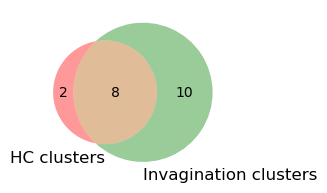

In [568]:
from matplotlib_venn import venn2

fig, ax = plt.subplots(figsize=(3, 3))
venn=venn2([set(np.array(hcCluster_all['AD'])[np.logical_and(np.array(hcCluster_all['AD'])!=-1,np.array(hcCluster_all_dff['AD'])>0)]), set(np.array(invagClusters_all['AD'])[np.logical_and(np.array(invagClusters_all['AD'])!=-1,np.array(invagClusters_all_diff['AD'])>0)])], set_labels=('HC clusters','Invagination clusters'))
plt.tight_layout()
plt.savefig(os.path.join(plotsavepath,'dapi','invag_hc_venn.pdf'))
# venn.subset_labels[0].set_text('\n'.join(set(np.array(hcClusters).astype(str)) - set(np.array(invagClusters).astype(str))))  # Only HC clusters
# venn.subset_labels[1].set_text('\n'.join(set(np.array(invagClusters).astype(str)) - set(np.array(hcClusters).astype(str))))  # Only Invagination clusters
# venn.subset_labels[2].set_text('\n'.join(set(np.array(hcClusters).astype(str)) & set(np.array(invagClusters).astype(str))))  # Intersection


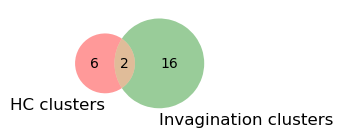

In [559]:
from matplotlib_venn import venn2

fig, ax = plt.subplots(figsize=(3, 3))
venn=venn2([set(np.array(hcCluster_all['AD'])[np.logical_and(np.array(hcCluster_all['AD'])!=-1,np.array(hcCluster_all_dff['AD'])<0)]), set(np.array(invagClusters_all['AD'])[np.logical_and(np.array(invagClusters_all['AD'])!=-1,np.array(invagClusters_all_diff['AD'])>0)])], set_labels=('HC clusters','Invagination clusters'))
plt.tight_layout()
plt.savefig(os.path.join(plotsavepath,'dapi','invag_hc_venn_lowhc.pdf'))
# venn.subset_labels[0].set_text('\n'.join(set(np.array(hcClusters).astype(str)) - set(np.array(invagClusters).astype(str))))  # Only HC clusters
# venn.subset_labels[1].set_text('\n'.join(set(np.array(invagClusters).astype(str)) - set(np.array(hcClusters).astype(str))))  # Only Invagination clusters
# venn.subset_labels[2].set_text('\n'.join(set(np.array(hcClusters).astype(str)) & set(np.array(invagClusters).astype(str))))  # Intersection


In [560]:
set(set(np.array(hcCluster_all['AD'])[np.logical_and(np.array(hcCluster_all['AD'])!=-1,np.array(hcCluster_all_dff['AD'])<0)])- set(np.array(invagClusters_all['AD'])[np.logical_and(np.array(invagClusters_all['AD'])!=-1,np.array(invagClusters_all_diff['AD'])>0)]))


{3, 6, 15, 18, 20, 38}

In [561]:
set(set(np.array(invagClusters_all['AD'])[np.logical_and(np.array(invagClusters_all['AD'])!=-1,np.array(invagClusters_all_diff['AD'])>0)])-set(np.array(hcCluster_all['AD'])[np.logical_and(np.array(hcCluster_all['AD'])!=-1,np.array(hcCluster_all_dff['AD'])<0)]))


{1, 4, 5, 7, 8, 10, 21, 22, 23, 30, 34, 36, 40, 46, 49, 74}

In [562]:
set(np.array(hcCluster_all['AD'])[np.logical_and(np.array(hcCluster_all['AD'])!=-1,np.array(hcCluster_all_dff['AD'])<0)])

{3, 6, 13, 15, 18, 20, 35, 38}

In [563]:
set(np.array(invagClusters_all['AD'])[np.logical_and(np.array(invagClusters_all['AD'])!=-1,np.array(invagClusters_all_diff['AD'])>0)])

{1, 4, 5, 7, 8, 10, 13, 21, 22, 23, 30, 34, 35, 36, 40, 46, 49, 74}

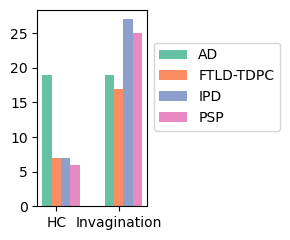

In [569]:
p2plot=['AD','FTLD-TDPC','IPD','PSP']
x=np.arange(2)
width=0.15
multiplier=0

colors = plt.cm.Set2(np.arange(4))
# colors = np.delete(colors, 2, axis=0) 
fig,ax=plt.subplots(figsize=(3,2.5),layout='constrained')
for tidx in range(len(p2plot)):
    t=p2plot[tidx]
    offset=width*multiplier
    counts=[len(hcCluster_all[t]),len(invagClusters_all[t])]
    bars=ax.bar(x+offset,counts,width,label=t,color=colors[tidx])
    multiplier+=1
    
ax.set_xticks(x+width,['HC','Invagination'])
ax.legend(loc='lower left',bbox_to_anchor=(1, 0.35))
# ax.set_ylim(0,1)
fig.tight_layout()
plt.savefig(os.path.join(plotsavepath,'dapi','invag_hc_clusterCounts.pdf'))

In [393]:
plotsavepath

'/data/xzhang/neuro/results/jointClustering/baseline/res5/cnnvaeexp0_segNucall/imgFeatures/byCluster'

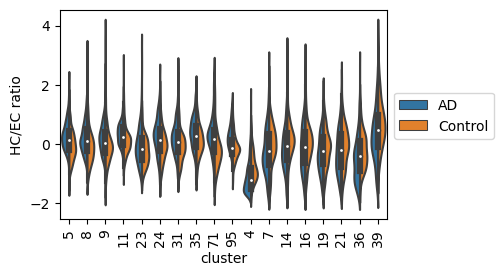

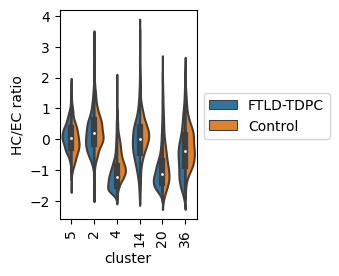

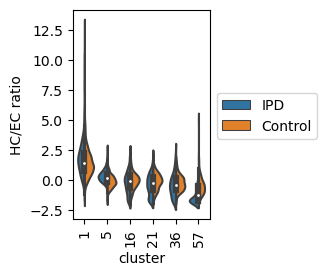

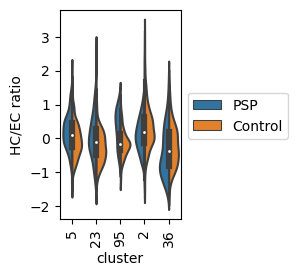

In [551]:
#4, 7
for p in np.unique(meta['Path Diag']):
    if p=='Control':
        continue
    ad_features=np.array([])
    clusterID_ad=np.array([])
    clusterID_control=np.array([])
    control_features=np.array([])
    for cidx in range(len(hcCluster_all[p])):
        c=hcCluster_all[p][cidx]
        if hcCluster_all_dff[p][cidx]>0 and c!=-1:
            ad_features_c=nmco_dapi[np.logical_and(meta.loc[allPatientIDs]['Path Diag']==p,finalPartition_keep_input==c),nmco_dapi_names=='hc_content_ec_content']
            control_features_c=nmco_dapi[np.logical_and(meta.loc[allPatientIDs]['Path Diag']=='Control',finalPartition_keep_input==c),nmco_dapi_names=='hc_content_ec_content']
            clusterID_ad=np.concatenate((clusterID_ad,np.repeat(str(int(c+1)),ad_features_c.size)))
            clusterID_control=np.concatenate((clusterID_control,np.repeat(str(int(c+1)),control_features_c.size)))
            ad_features=np.concatenate((ad_features,ad_features_c))
            control_features=np.concatenate((control_features,control_features_c))
    for cidx in range(len(hcCluster_all[p])):
        c=hcCluster_all[p][cidx]
        if hcCluster_all_dff[p][cidx]<0 and c!=-1:
            ad_features_c=nmco_dapi[np.logical_and(meta.loc[allPatientIDs]['Path Diag']==p,finalPartition_keep_input==c),nmco_dapi_names=='hc_content_ec_content']
            control_features_c=nmco_dapi[np.logical_and(meta.loc[allPatientIDs]['Path Diag']=='Control',finalPartition_keep_input==c),nmco_dapi_names=='hc_content_ec_content']
            clusterID_ad=np.concatenate((clusterID_ad,np.repeat(str(int(c+1)),ad_features_c.size)))
            clusterID_control=np.concatenate((clusterID_control,np.repeat(str(int(c+1)),control_features_c.size)))
            ad_features=np.concatenate((ad_features,ad_features_c))
            control_features=np.concatenate((control_features,control_features_c))

    nmcoplot=pd.DataFrame({'pheno':np.concatenate((np.repeat(p,ad_features.size),np.repeat('Control',control_features.size))),'HC/EC ratio':np.concatenate((ad_features,control_features)),'cluster':np.concatenate((clusterID_ad,clusterID_control))})
    fig,ax=plt.subplots(figsize=(4.5/(len(hcCluster_all['AD'])+3)*(len(hcCluster_all[p])+3),3),layout='constrained')
    sns.violinplot(nmcoplot,y='HC/EC ratio',x='cluster',hue='pheno',split=True)
    ax.legend(loc='lower left',bbox_to_anchor=(1, 0.35))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#     plt.ylim(-2,4)
    plt.savefig(os.path.join(plotsavepath,'dapi','hc_content_ec_content',p+'_Control_shifted.pdf'))
    fig.tight_layout()
    plt.show()

In [603]:
plotsavepath

'/data/xzhang/neuro/results/jointClustering/baseline/res5/cnnvaeexp0_segNucall/imgFeatures/byCluster'

In [554]:
np.array(hcCluster_all['AD'])[np.array(hcCluster_all_dff['AD'])<0]

array([-1,  3,  6, 13, 15, 18, 20, 35, 38])

In [531]:
vidx=2
c=7
p='AD'
imgSize=allImg.shape[3]
valStains_curr=stains[vidx]
print(valStains_curr)
valStains_currIdx=stains.tolist().index(valStains_curr)
nExamples=20
# add clf and gradient
plotExample=np.zeros((2*imgSize+2,nExamples*(imgSize+2),3))
ad_idx=np.arange(allImg.shape[0])[np.logical_and(meta.loc[allPatientIDs]['Path Diag']==p,finalPartition_keep_input==c)]
control_idx=np.arange(allImg.shape[0])[np.logical_and(meta.loc[allPatientIDs]['Path Diag']=='Control',finalPartition_keep_input==c)]

np.random.seed(3)
np.random.shuffle(ad_idx)
np.random.seed(3)
np.random.shuffle(control_idx)
plotIdx_ad=ad_idx[:min(ad_idx.size,nExamples)]
plotIdx_control=control_idx[:min(control_idx.size,nExamples)]
print('sampled')
for plotIdx_idx in range(plotIdx_ad.size):
    plotExample[:imgSize,plotIdx_idx*(imgSize+2):plotIdx_idx*(imgSize+2)+imgSize,0]=allImg[plotIdx_ad[plotIdx_idx],valStains_currIdx]
for plotIdx_idx in range(plotIdx_control.size):
    plotExample[imgSize+2:,plotIdx_idx*(imgSize+2):plotIdx_idx*(imgSize+2)+imgSize,0]=allImg[plotIdx_control[plotIdx_idx],valStains_currIdx]
plt.imsave(os.path.join(plotsavepath,'dapi','hc_content_ec_content','plotExample_'+p+'_'+str(c)+'_'+valStains_curr+'.jpg'),plotExample)


MAP2
sampled


In [ ]:
ad_idx

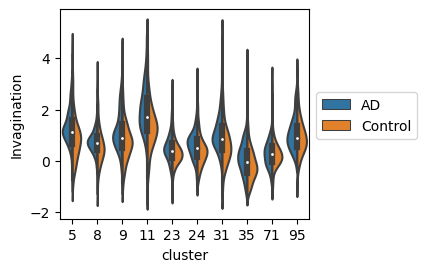

/tmp/ipykernel_1048967/2836900901.py:22: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig(os.path.join(plotsavepath,'dapi','hc_content_ec_content',p+'_Control_invag_shifted.pdf'))
/tmp/ipykernel_1048967/2836900901.py:22: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig(os.path.join(plotsavepath,'dapi','hc_content_ec_content',p+'_Control_invag_shifted.pdf'))
/tmp/ipykernel_1048967/2836900901.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


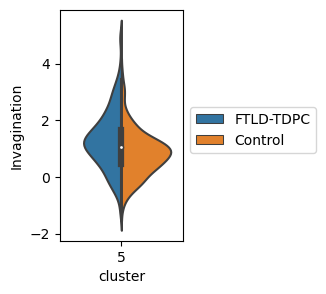

/tmp/ipykernel_1048967/2836900901.py:22: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig(os.path.join(plotsavepath,'dapi','hc_content_ec_content',p+'_Control_invag_shifted.pdf'))
/tmp/ipykernel_1048967/2836900901.py:22: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig(os.path.join(plotsavepath,'dapi','hc_content_ec_content',p+'_Control_invag_shifted.pdf'))
/tmp/ipykernel_1048967/2836900901.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


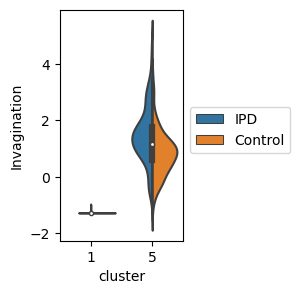

/tmp/ipykernel_1048967/2836900901.py:22: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig(os.path.join(plotsavepath,'dapi','hc_content_ec_content',p+'_Control_invag_shifted.pdf'))
/tmp/ipykernel_1048967/2836900901.py:22: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig(os.path.join(plotsavepath,'dapi','hc_content_ec_content',p+'_Control_invag_shifted.pdf'))
/tmp/ipykernel_1048967/2836900901.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


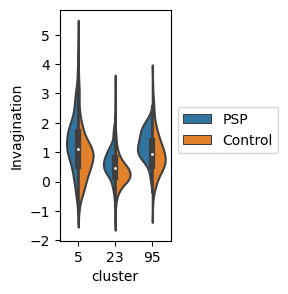

In [557]:
#4, 7
for p in np.unique(meta['Path Diag']):
    if p=='Control':
        continue
    ad_features=np.array([])
    clusterID_ad=np.array([])
    clusterID_control=np.array([])
    control_features=np.array([])
    for c in np.array(hcCluster_all[p])[np.array(hcCluster_all_dff[p])>0]:
        ad_features_c=nmco_lmnb[np.logical_and(meta.loc[allPatientIDs]['Path Diag']==p,finalPartition_keep_input==c),nmco_lmnb_names=='invagination']
        control_features_c=nmco_lmnb[np.logical_and(meta.loc[allPatientIDs]['Path Diag']=='Control',finalPartition_keep_input==c),nmco_lmnb_names=='invagination']
        clusterID_ad=np.concatenate((clusterID_ad,np.repeat(str(int(c)+1),ad_features_c.size)))
        clusterID_control=np.concatenate((clusterID_control,np.repeat(str(int(c)+1),control_features_c.size)))
        ad_features=np.concatenate((ad_features,ad_features_c))
        control_features=np.concatenate((control_features,control_features_c))

    fig,ax=plt.subplots(figsize=(3.5/(len(hcCluster_all['AD'])+3)*(len(hcCluster_all[p])+3),3),layout='constrained')
    nmcoplot=pd.DataFrame({'pheno':np.concatenate((np.repeat(p,ad_features.size),np.repeat('Control',control_features.size))),'Invagination':np.concatenate((ad_features,control_features)),'cluster':np.concatenate((clusterID_ad,clusterID_control))})
    sns.violinplot(nmcoplot,y='Invagination',x='cluster',hue='pheno',split=True)
#     plt.ylim(-2,5)
    ax.legend(loc='lower left',bbox_to_anchor=(1, 0.35))
    plt.savefig(os.path.join(plotsavepath,'dapi','hc_content_ec_content',p+'_Control_invag_shifted.pdf'))
    fig.tight_layout()
    plt.show()